# AethraDB All Query Result Analysis Overview
This file contains the result analysis for the filter query aggregation and join queries at the current stage of development in the AethraDB engine. Additionally, it contains a comparison against a single-threaded run of the same queries on the same data on DuckDB version 0.8.1 using PyArrow 13.0.0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('tableau-colorblind10')
plt_patterns = ('-', 'x','/','\\','O','o','//','\\\\')

In [2]:
# Load the data from AethraDB
aethra_results = pd.read_csv("./main_method_benchmark_result_2023-10-11_21:40:28-openjdk-XPS.csv")

aethra_results.head()

,Benchmark,Dataset,Scale-Factor,Paradigm,Repetitions,ResultSummarised,Planning-Time,Codegen-Time,Compilation-Time,Execution-Time,Total-Time
0,filter_query,filter_query_int_rest_1,1,non-vectorised,10,False,10.3,1.8,55.5,130.5,228.1
1,filter_query,filter_query_int_rest_1,1,vectorised,10,False,10.2,1.3,55.7,106.5,203.9
2,filter_query,filter_query_int_rest_1,10,non-vectorised,10,False,11.5,2.7,59.1,746.2,849.4
3,filter_query,filter_query_int_rest_1,10,vectorised,10,False,10.5,2.3,59.0,541.9,643.4
4,filter_query,filter_query_int_rest_1,20,non-vectorised,10,False,12.5,4.0,62.5,1422.2,1531.0


# Analysis of the Filter Query at different Scale Factors

In [3]:
# Get the data of the filter query
filter_query = aethra_results[aethra_results['Benchmark'] == 'filter_query'].copy(deep=True)

# Extract the restrictive column
filter_query["Restrictive-Column"] = filter_query.apply(lambda x: 1 if 'rest_1' in x['Dataset'] else (2 if 'rest_2' in x['Dataset'] else 3), axis=1)

filter_query.head()

,Benchmark,Dataset,Scale-Factor,Paradigm,Repetitions,ResultSummarised,Planning-Time,Codegen-Time,Compilation-Time,Execution-Time,Total-Time,Restrictive-Column
0,filter_query,filter_query_int_rest_1,1,non-vectorised,10,False,10.3,1.8,55.5,130.5,228.1,1
1,filter_query,filter_query_int_rest_1,1,vectorised,10,False,10.2,1.3,55.7,106.5,203.9,1
2,filter_query,filter_query_int_rest_1,10,non-vectorised,10,False,11.5,2.7,59.1,746.2,849.4,1
3,filter_query,filter_query_int_rest_1,10,vectorised,10,False,10.5,2.3,59.0,541.9,643.4,1
4,filter_query,filter_query_int_rest_1,20,non-vectorised,10,False,12.5,4.0,62.5,1422.2,1531.0,1


In [4]:
# Load duckdb reference data
filter_query_duck = pd.read_csv("duckdb_filter_query_result_XPS.csv")
filter_query_duck.head()

,Running-Time,Scale-Factor,Engine,Restrictive-Column
0,70.4,1,DuckDB,1
1,68.9,1,DuckDB,2
2,70.0,1,DuckDB,3
3,698.4,10,DuckDB,1
4,680.7,10,DuckDB,2


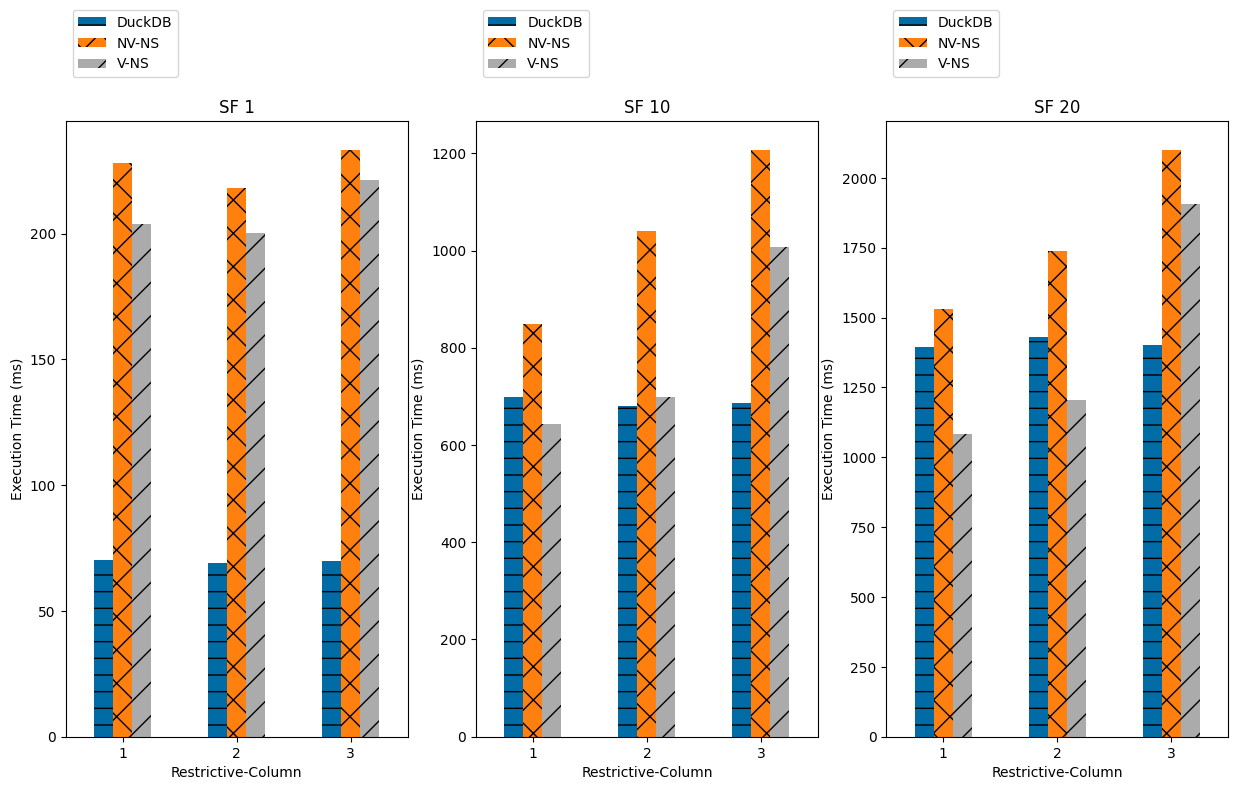

In [5]:
index_column = "Restrictive-Column"
scale_factors = [1, 10, 20]

fig, ax = plt.subplots(nrows=1, ncols=len(scale_factors), figsize=(15,8))

for i, sf in enumerate(scale_factors):
    duckdb_data = filter_query_duck[filter_query_duck["Scale-Factor"] == sf].sort_values(index_column)
    index = duckdb_data[index_column]

    aethra_data = filter_query[filter_query["Scale-Factor"] == sf].sort_values(index_column)
    aethra_nv_ns_data = aethra_data[aethra_data["Paradigm"] == "non-vectorised"]
    aethra_v_ns_data = aethra_data[aethra_data["Paradigm"] == "vectorised"]

    df = pd.DataFrame({
        'DuckDB': duckdb_data["Running-Time"].tolist(),
        'NV-NS': aethra_nv_ns_data["Total-Time"].tolist(),
        'V-NS': aethra_v_ns_data["Total-Time"].tolist(),
    }, index = index)

    df.plot.bar(rot=0, ax=ax[i])
    ax[i].set_ylabel("Execution Time (ms)")
    ax[i].set_title("SF " + str(sf))

    bars = ax[i].patches
    hatches = [p for p in plt_patterns for j in range(len(df))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax[i].legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

# Analysis of the Aggregation Query at different Scale Factors

In [6]:
# Get the data of the aggregation query
aggregation_query = aethra_results[aethra_results['Benchmark'] == 'aggregation_query'].copy(deep=True)

# Extract the number of keys in the result
aggregation_query["Keys"] = aggregation_query.apply(lambda x: x['Dataset'].split('keys_')[1], axis=1)
aggregation_query["Keys"] = aggregation_query["Keys"].str.extract('(\d+)').astype(int)

aggregation_query.head()

,Benchmark,Dataset,Scale-Factor,Paradigm,Repetitions,ResultSummarised,Planning-Time,Codegen-Time,Compilation-Time,Execution-Time,Total-Time,Keys
18,aggregation_query,aggregation_query_int_keys_2,1,non-vectorised,10,True,11.8,1.4,56.5,215.7,315.2,2
19,aggregation_query,aggregation_query_int_keys_2,1,vectorised,10,True,10.4,1.4,56.8,214.9,313.4,2
20,aggregation_query,aggregation_query_int_keys_2,10,non-vectorised,10,True,12.3,2.5,60.5,1747.1,1852.3,2
21,aggregation_query,aggregation_query_int_keys_2,10,vectorised,10,True,10.7,2.4,60.5,1685.3,1788.6,2
22,aggregation_query,aggregation_query_int_keys_2,20,non-vectorised,10,True,12.7,3.6,64.2,3434.3,3545.2,2


In [7]:
# Load duckdb reference data
aggregation_query_duck = pd.read_csv("duckdb_aggregation_query_result_XPS.csv")
aggregation_query_duck.head()

,Running-Time,Scale-Factor,Engine,Keys
0,2028.5,1,DuckDB,524288
1,1651.3,1,DuckDB,262144
2,440.0,1,DuckDB,16
3,840.1,1,DuckDB,8192
4,438.3,1,DuckDB,2


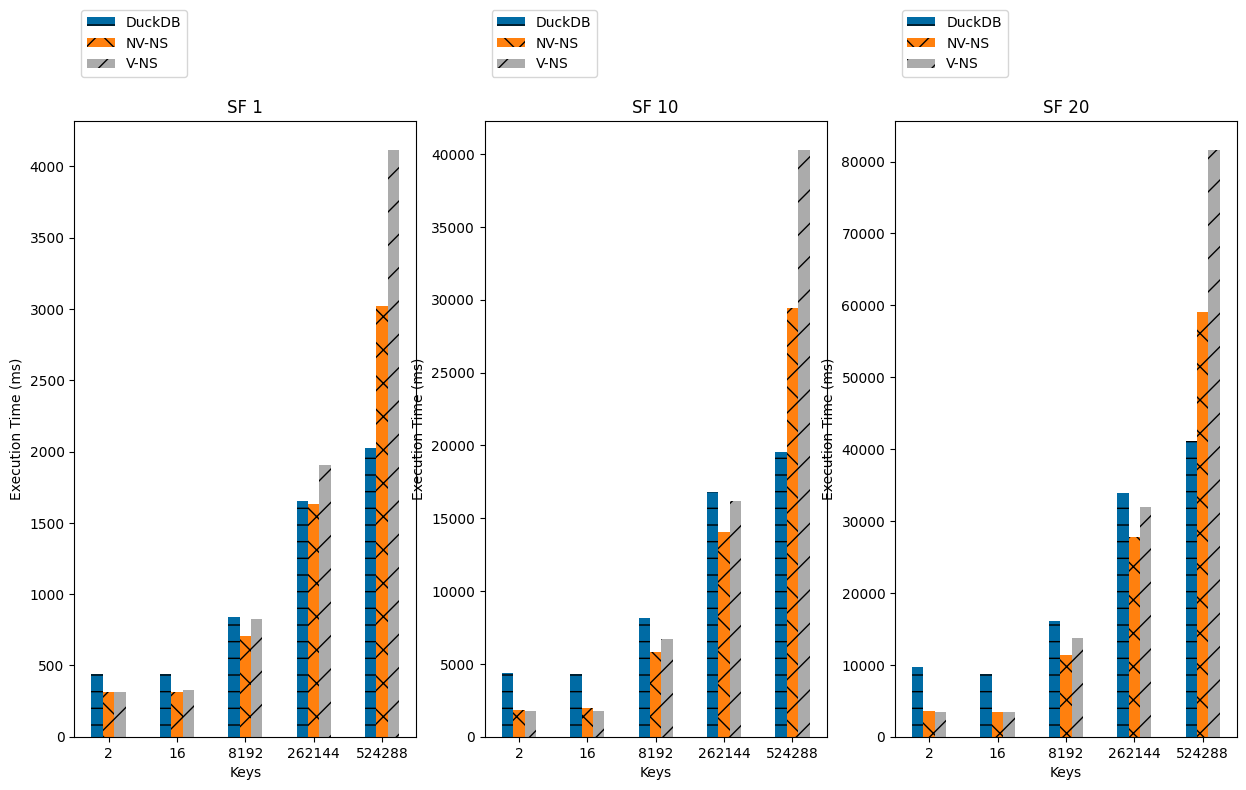

In [8]:
index_column = "Keys"
scale_factors = [1, 10, 20]

fig, ax = plt.subplots(nrows=1, ncols=len(scale_factors), figsize=(15,8))

for i, sf in enumerate(scale_factors):
    duckdb_data = aggregation_query_duck[aggregation_query_duck["Scale-Factor"] == sf].sort_values(index_column)
    index = duckdb_data[index_column]

    aethra_data = aggregation_query[aggregation_query["Scale-Factor"] == sf].sort_values(index_column)
    aethra_nv_ns_data = aethra_data[aethra_data["Paradigm"] == "non-vectorised"]
    aethra_v_ns_data = aethra_data[aethra_data["Paradigm"] == "vectorised"]

    df = pd.DataFrame({
        'DuckDB': duckdb_data["Running-Time"].tolist(),
        'NV-NS': aethra_nv_ns_data["Total-Time"].tolist(),
        'V-NS': aethra_v_ns_data["Total-Time"].tolist(),
    }, index = index)

    df.plot.bar(rot=0, ax=ax[i])
    ax[i].set_ylabel("Execution Time (ms)")
    ax[i].set_title("SF " + str(sf))

    bars = ax[i].patches
    hatches = [p for p in plt_patterns for j in range(len(df))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax[i].legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

# Analysis of the Join Query at different Scale Factors
For this experiment, we only ran the query at selectivity instance A-B 0.6, A-C 0.8

In [9]:
# Get the data of the join query
join_query = aethra_results[aethra_results['Benchmark'] == 'join_query'].copy(deep=True)

# No need to get the selectivity of each join, since the experiment was only run at A-B 0.6, A-C 0.8

join_query.head()

,Benchmark,Dataset,Scale-Factor,Paradigm,Repetitions,ResultSummarised,Planning-Time,Codegen-Time,Compilation-Time,Execution-Time,Total-Time
48,join_query,join_query_int_B_0.6_C_0.8,1,non-vectorised,10,True,11.5,1.6,57.2,2221.3,2321.9
49,join_query,join_query_int_B_0.6_C_0.8,1,vectorised,10,True,9.8,1.5,57.2,2025.9,2124.7
50,join_query,join_query_int_B_0.6_C_0.8,10,non-vectorised,10,True,11.6,1.8,60.1,23592.2,23696.5
51,join_query,join_query_int_B_0.6_C_0.8,10,vectorised,10,True,9.9,1.8,60.1,21269.6,21371.8


In [10]:
# Load duckdb reference data
join_query_duck = pd.read_csv("duckdb_join_query_result_XPS.csv")
join_query_duck.head()

,Running-Time,Scale-Factor,Engine
0,685.8,1,DuckDB
1,8609.7,10,DuckDB


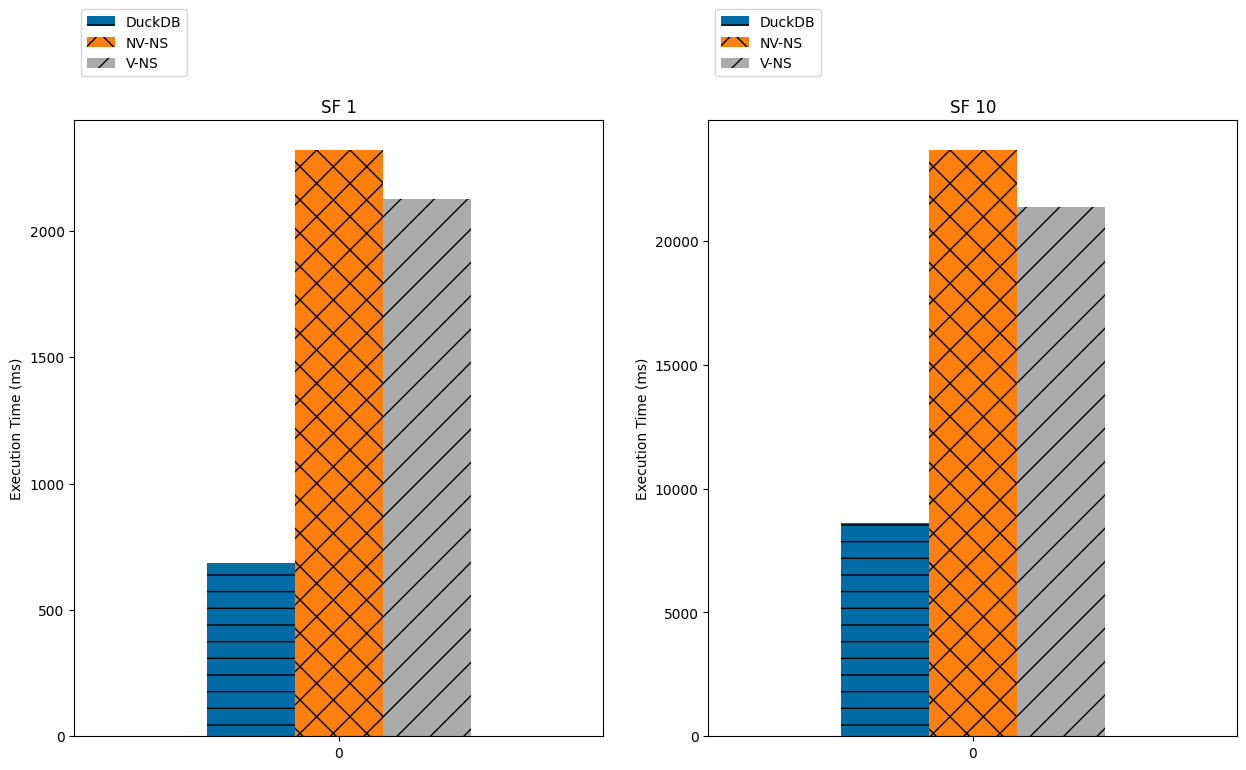

In [11]:
scale_factors = [1, 10]

fig, ax = plt.subplots(nrows=1, ncols=len(scale_factors), figsize=(15,8))

for i, sf in enumerate(scale_factors):
    duckdb_data = join_query_duck[join_query_duck["Scale-Factor"] == sf]

    aethra_data = join_query[join_query["Scale-Factor"] == sf]
    aethra_nv_ns_data = aethra_data[aethra_data["Paradigm"] == "non-vectorised"]
    aethra_v_ns_data = aethra_data[aethra_data["Paradigm"] == "vectorised"]

    df = pd.DataFrame({
        'DuckDB': duckdb_data["Running-Time"].tolist(),
        'NV-NS': aethra_nv_ns_data["Total-Time"].tolist(),
        'V-NS': aethra_v_ns_data["Total-Time"].tolist()
    })

    df.plot.bar(rot=0, ax=ax[i])
    ax[i].set_ylabel("Execution Time (ms)")
    ax[i].set_title("SF " + str(sf))

    bars = ax[i].patches
    hatches = [p for p in plt_patterns for j in range(len(df))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax[i].legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))

# Analysis of TPC-H Q1 at different Scale Factors

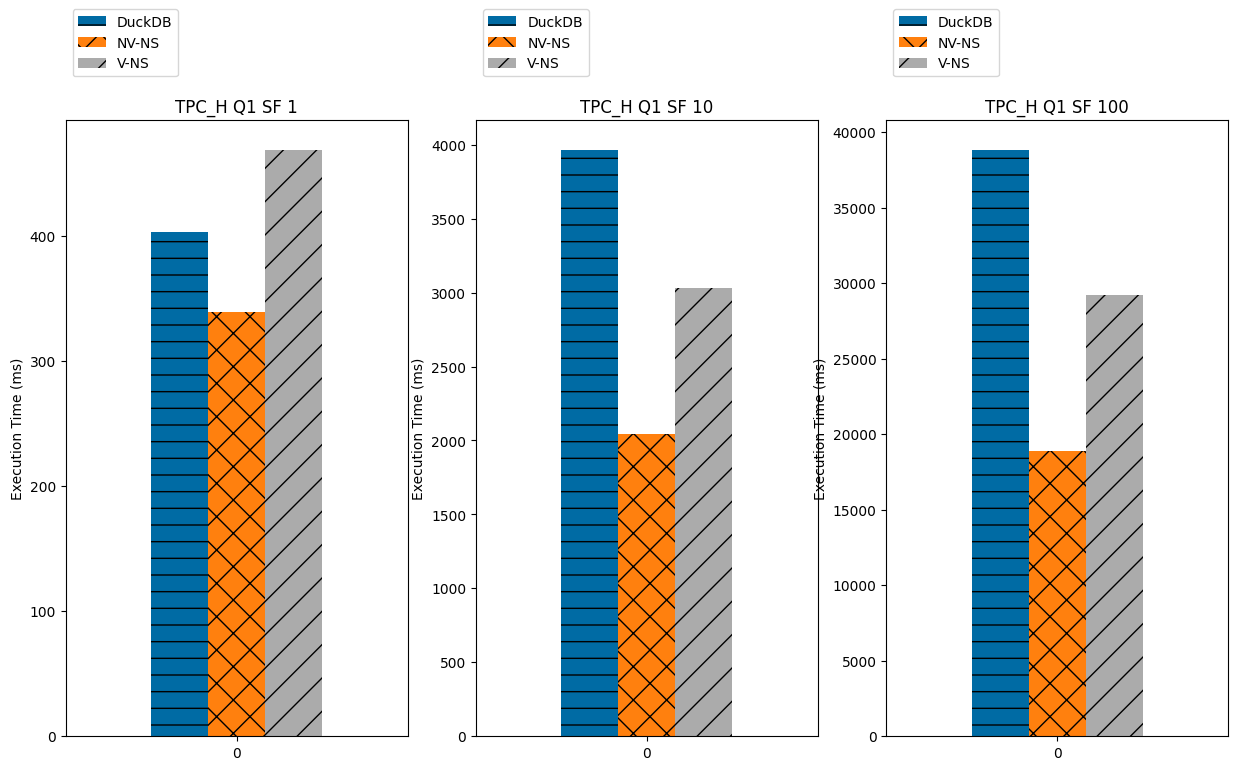

In [12]:
def plot_tpch_data(query_number):
    # Get the data of the query
    tpch_data = aethra_results[aethra_results['Benchmark'].str.contains('tpch')].copy(deep=True)    
    tpch_query_data = tpch_data[tpch_data['Benchmark'] == "tpch_q" + str(query_number)].copy(deep=True)
    
    # Load duckdb reference data
    tpch_query_duck = pd.read_csv("duckdb_tpch_q" + str(query_number) + "_query_result_XPS.csv")
    
    # Obtain the different scale factors
    sf_vals = tpch_query_data["Scale-Factor"].unique()
    sf_vals.sort()
    scale_factors = list(sf_vals)

    # Plot the data
    fig, ax = plt.subplots(nrows=1, ncols=len(scale_factors), figsize=(15,8))

    for i, sf in enumerate(scale_factors):
        duckdb_data = tpch_query_duck[tpch_query_duck["Scale-Factor"] == sf]

        aethra_data = tpch_query_data[tpch_query_data["Scale-Factor"] == sf]
        aethra_nv_ns_data = aethra_data[aethra_data["Paradigm"] == "non-vectorised"]
        aethra_v_ns_data = aethra_data[aethra_data["Paradigm"] == "vectorised"]

        df = pd.DataFrame({
            'DuckDB': duckdb_data["Running-Time"].tolist(),
            'NV-NS': aethra_nv_ns_data["Total-Time"].tolist(),
            'V-NS': aethra_v_ns_data["Total-Time"].tolist(),
        })

        df.plot.bar(rot=0, ax=ax[i])
        ax[i].set_ylabel("Execution Time (ms)")
        ax[i].set_title("TPC_H Q" + str(query_number) + " SF " + str(sf))

        bars = ax[i].patches
        hatches = [p for p in plt_patterns for j in range(len(df))]
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)

        ax[i].legend(loc=3, bbox_to_anchor=(0., 1.06, 1., .102))
    

plot_tpch_data(1)

# Analysis of TPC-H Q3 at different Scale Factors

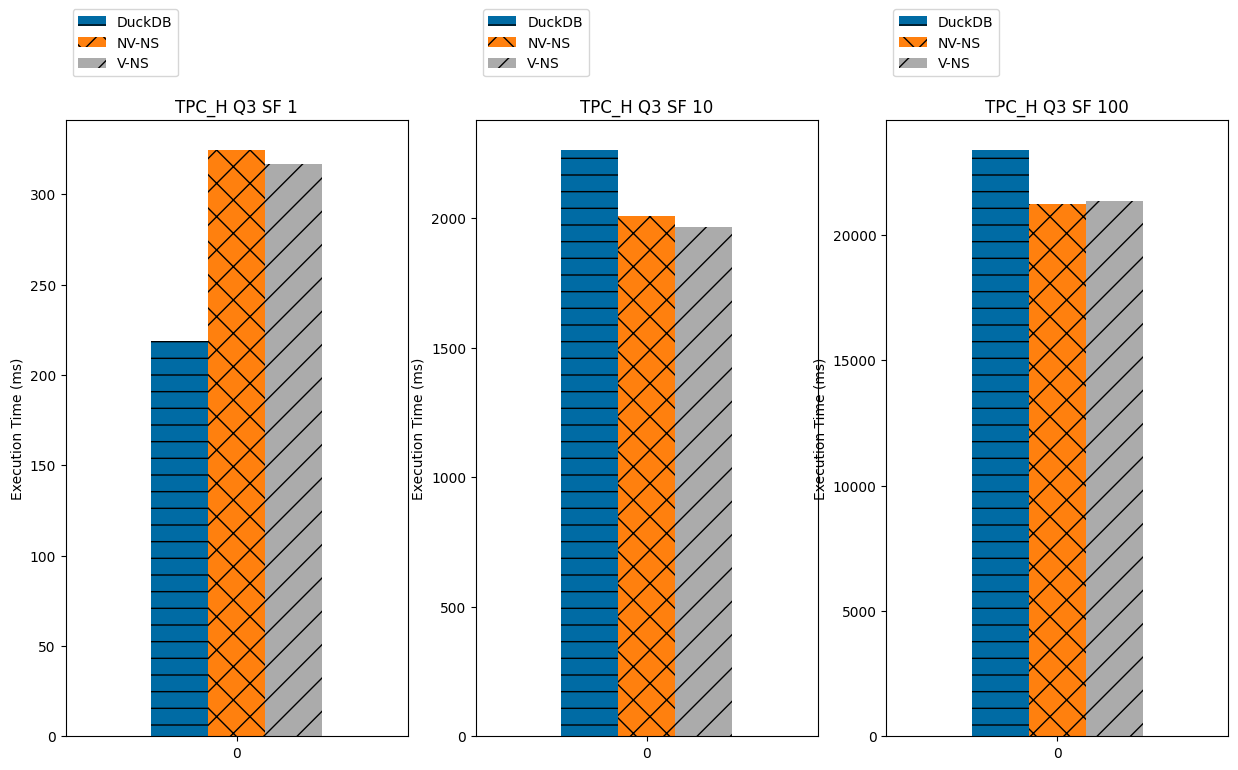

In [13]:
plot_tpch_data(3)

# Analysis of TPC-H Q6 at different Scale Factors

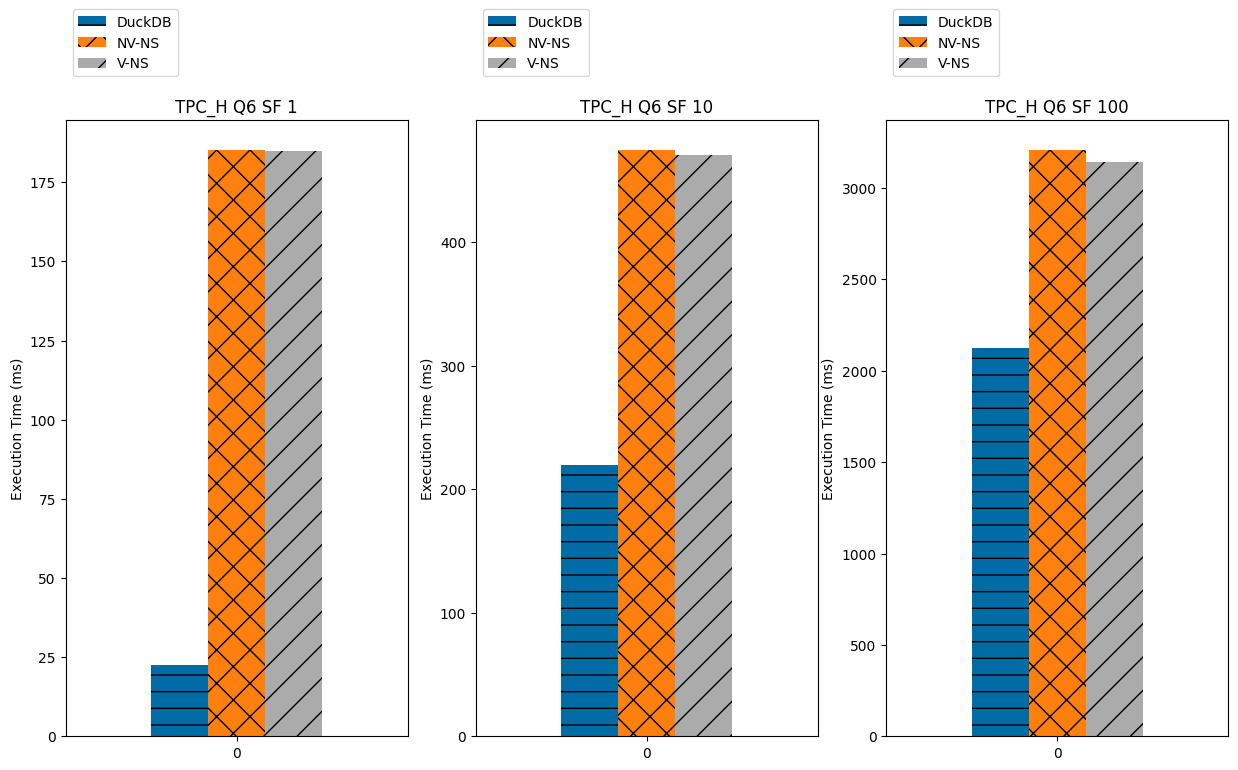

In [14]:
plot_tpch_data(6)

# Analysis of TPC-H Q10 at different Scale Factors

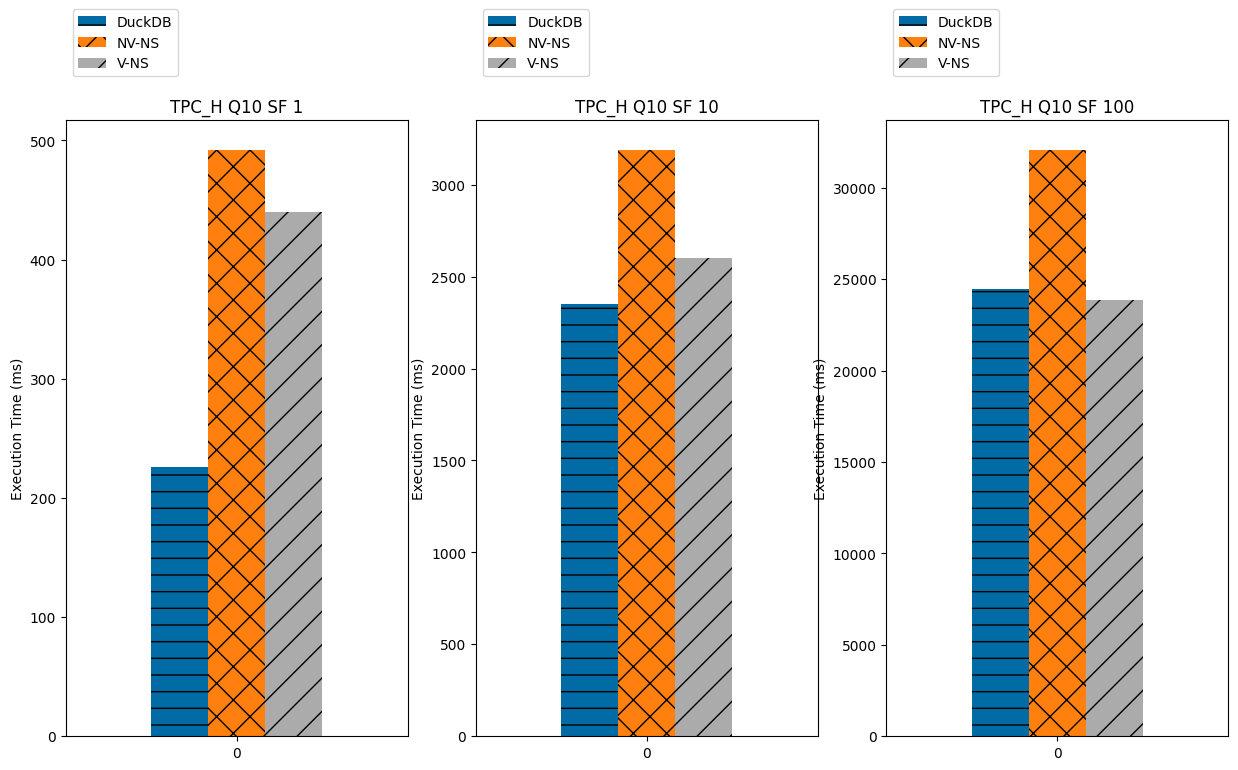

In [15]:
plot_tpch_data(10)